In [ ]:
!pip install pandas sqlalchemy matplotlib seaborn psycopg2-binary


Chargement des données depuis PostgreSQL...
Données chargées avec succès.
Préparation des données pour la distribution des sentiments...
Données de sentiments simulées.
Préparation des données pour la fréquence des toots...
Données de fréquence des toots préparées.
Préparation des données pour les hashtags les plus fréquents...
Données des hashtags préparées.
Préparation des données pour l'activité des utilisateurs...
Données de l'activité des utilisateurs préparées.
Création de la visualisation : Distribution des sentiments...


/tmp/ipykernel_448/2477896770.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=filtered_toots, palette='viridis')


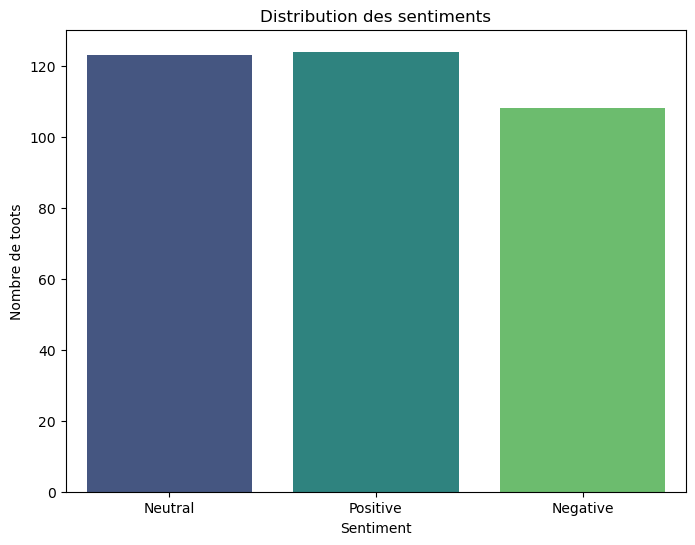

Création de la visualisation : Fréquence des toots au fil du temps...


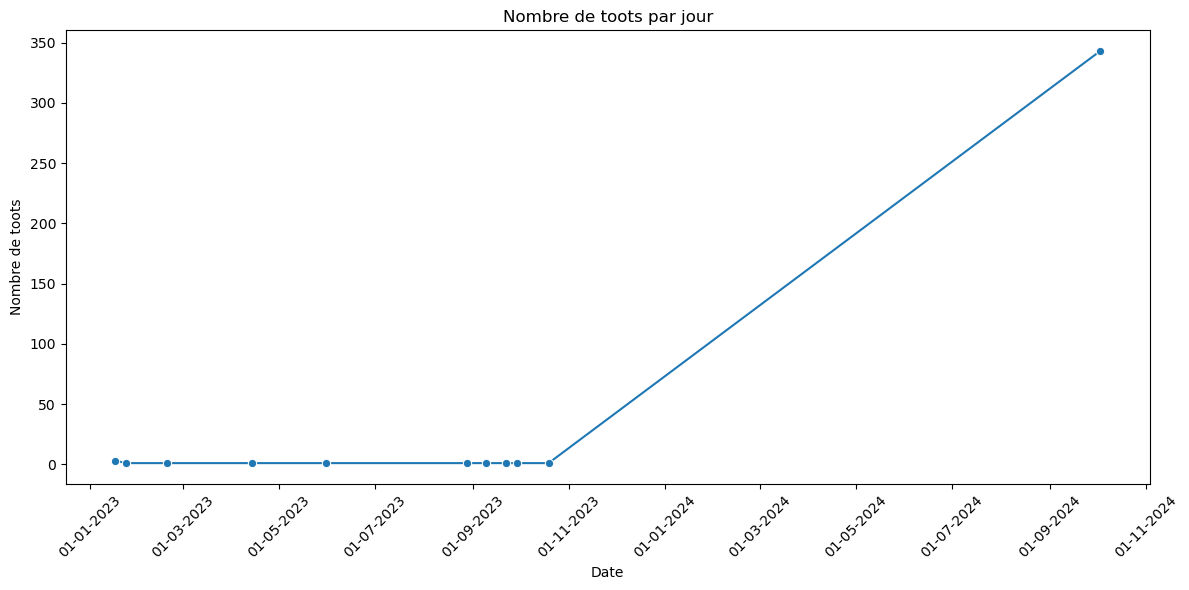

Création de la visualisation : Hashtags les plus fréquents...


/tmp/ipykernel_448/2477896770.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='hashtag', data=top_hashtags, palette='coolwarm')


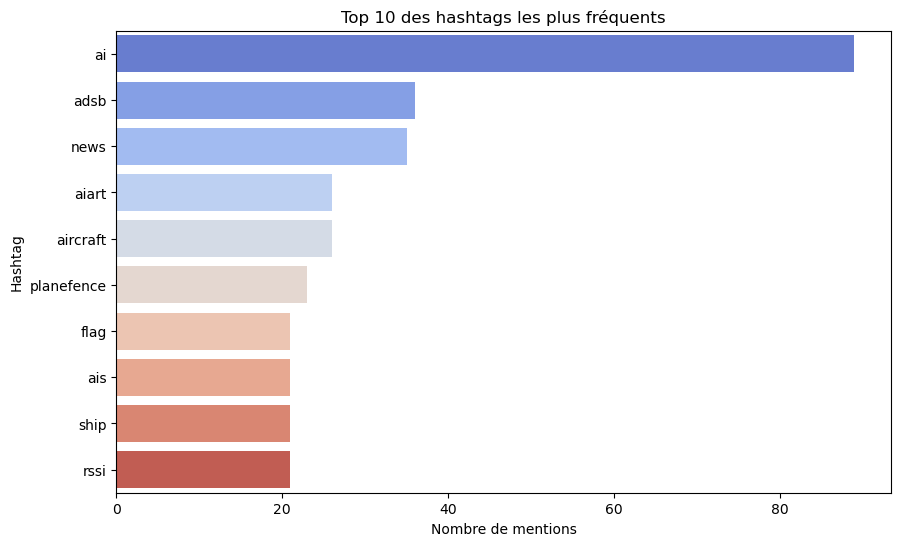

Création de la visualisation : Activité des utilisateurs...


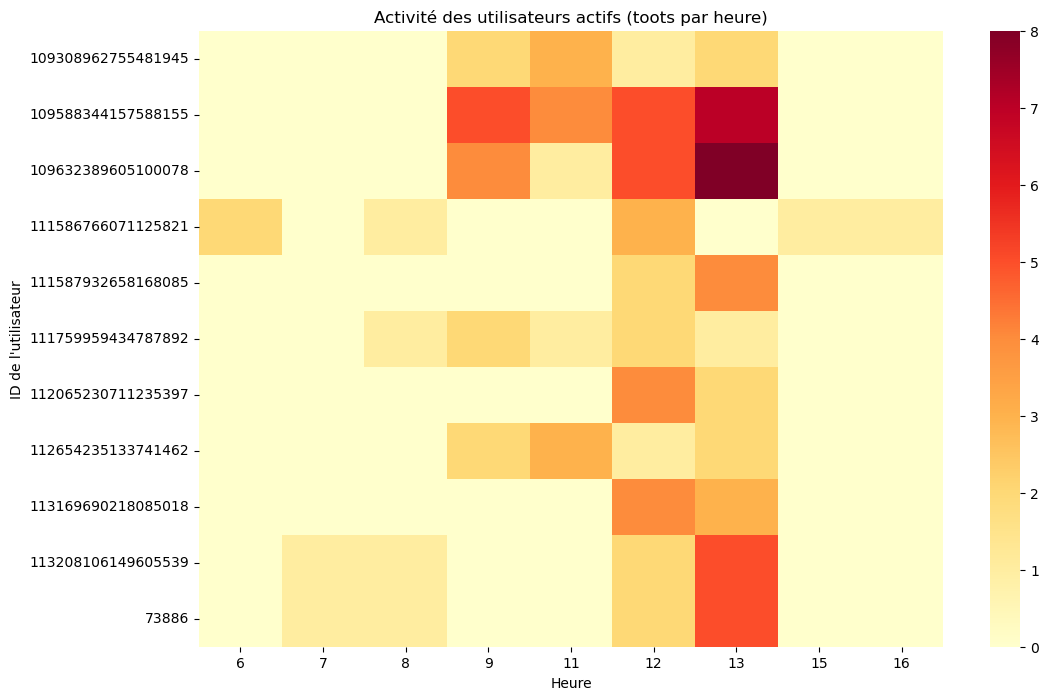

Visualisations créées avec succès.


In [6]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

# Paramètres de connexion à PostgreSQL
db_host = "some-postgres"
db_port = "5432"
db_name = "mastodon_data"
db_user = "postgres"
db_password = "mysecretpassword"

# Crée l'URL de connexion
db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Crée un moteur SQLAlchemy
engine = create_engine(db_url)

# Charge les données nécessaires depuis PostgreSQL
print("Chargement des données depuis PostgreSQL...")
filtered_toots = pd.read_sql("SELECT * FROM filtered_toots", engine)
user_avg_length = pd.read_sql("SELECT * FROM user_avg_length", engine)
hashtag_avg_length = pd.read_sql("SELECT * FROM hashtag_avg_length", engine)
toots_time_window = pd.read_sql("SELECT * FROM toots_time_window_aggregates", engine)
print("Données chargées avec succès.")


# Prépare les données pour la distribution des sentiments
print("Préparation des données pour la distribution des sentiments...")
np.random.seed(42)  # Pour la reproductibilité
sentiments = ['Positive', 'Negative', 'Neutral']
filtered_toots['sentiment'] = np.random.choice(sentiments, size=len(filtered_toots))
print("Données de sentiments simulées.")

# Prépare les données pour la fréquence des toots
print("Préparation des données pour la fréquence des toots...")
filtered_toots['timestamp'] = pd.to_datetime(filtered_toots['timestamp'])
filtered_toots['date'] = filtered_toots['timestamp'].dt.date
toots_per_day = filtered_toots.groupby('date').size().reset_index(name='toot_count')
print("Données de fréquence des toots préparées.")

# Prépare les données pour les hashtags les plus fréquents
print("Préparation des données pour les hashtags les plus fréquents...")
filtered_toots['hashtags_list'] = filtered_toots['hashtags'].str.split(',')
hashtags_exploded = filtered_toots.explode('hashtags_list')
hashtag_counts = hashtags_exploded['hashtags_list'].value_counts().reset_index()
hashtag_counts.columns = ['hashtag', 'count']
print("Données des hashtags préparées.")

# Préparer les données pour l'activité des utilisateurs
print("Préparation des données pour l'activité des utilisateurs...")
user_activity = filtered_toots.groupby('user_id').size().reset_index(name='toot_count')
print("Données de l'activité des utilisateurs préparées.")


# Distribution des sentiments
print("Création de la visualisation : Distribution des sentiments...")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=filtered_toots, palette='viridis')
plt.title('Distribution des sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de toots')
plt.show()

# Fréquence des toots au fil du temps
print("Création de la visualisation : Fréquence des toots au fil du temps...")
toots_per_day = toots_per_day.sort_values('date')
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='toot_count', data=toots_per_day, marker='o')
date_formatter = mdates.DateFormatter('%d-%m-%Y')
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.title('Nombre de toots par jour')
plt.xlabel('Date')
plt.ylabel('Nombre de toots')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Création de la visualisation : Hashtags les plus fréquents...")
# Filtre les hashtags non vides
hashtag_counts = hashtag_counts[hashtag_counts['hashtag'] != '']
# Sélectionne les top 10 hashtags
top_hashtags = hashtag_counts.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='hashtag', data=top_hashtags, palette='coolwarm')
plt.title('Top 10 des hashtags les plus fréquents')
plt.xlabel('Nombre de mentions')
plt.ylabel('Hashtag')
plt.show()

print("Création de la visualisation : Activité des utilisateurs...")
filtered_toots['hour'] = filtered_toots['timestamp'].dt.hour
user_activity_time = filtered_toots.groupby(['user_id', 'hour']).size().reset_index(name='toot_count')
active_users = user_activity[user_activity['toot_count'] > 5]['user_id']
filtered_activity = user_activity_time[user_activity_time['user_id'].isin(active_users)]
activity_pivot_active = filtered_activity.pivot(index='user_id', columns='hour', values='toot_count').fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(activity_pivot_active, cmap='YlOrRd')
plt.title('Activité des utilisateurs actifs (toots par heure)')
plt.xlabel('Heure')
plt.ylabel('ID de l\'utilisateur')
plt.show()

print("Visualisations créées avec succès.")
